# Predicting the price of Spanish wines

This project concerns a linear regression model for the prediction of the price of Spanish red wines. It is based on a dataset obtained from kaggle (https://www.kaggle.com/datasets/fedesoriano/spanish-wine-quality-dataset) which was created from web scrapings of various sites, from wine specialized pages to supermarkets.

A description by the dataset creator of the included variables follows:

__winery__: Winery name <br>
__wine__: Name of the wine <br>
__year__: Year in which the grapes were harvested <br>
__rating__: Average rating given to the wine by the users [from 1-5] <br>
__num_reviews__: Number of users that reviewed the wine <br>
__country__: Country of origin [Spain] <br>
__region__: Region of the wine <br>
__price__: Price in euros [€] <br>
__type__: Wine variety <br>
__body__: Body score, defined as the richness and weight of the wine in your mouth [from 1-5] <br>
__acidity__: Acidity score, defined as wine's “pucker” or tartness; it's what makes a wine refreshing and your tongue salivate and want another sip [from 1-5]

In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.linear_model import LassoCV

I first read the dataset into a pandas dataframe and shuffled it.

In [2]:
spanishWines = pd.read_csv('wines_SPA.csv')
spanishWines = spanishWines.sample(frac=1)

I then examined descriptives of the numerical variables, a few sample rows, the data types of the columns and I searched for missing data.

            rating   num_reviews        price         body      acidity
count  7500.000000   7500.000000  7500.000000  6331.000000  6331.000000
mean      4.254933    451.109067    60.095822     4.158427     2.946612
std       0.118029    723.001856   150.356676     0.583352     0.248202
min       4.200000     25.000000     4.990000     2.000000     1.000000
25%       4.200000    389.000000    18.900000     4.000000     3.000000
50%       4.200000    404.000000    28.530000     4.000000     3.000000
75%       4.200000    415.000000    51.350000     5.000000     3.000000
max       4.900000  32624.000000  3119.080000     5.000000     3.000000



                    winery                     wine  year  rating  \
5570  Conreria d'Scala Dei            Les Brugueres  2018     4.2   
1562                  Muga  Prado Enea Gran Reserva  1985     4.3   
2463    Portal del Priorat    Clos del Portal Somni  2014     4.2   
832                 Artadi            Vina El Pison  2007     4.4   
2618

<AxesSubplot:>

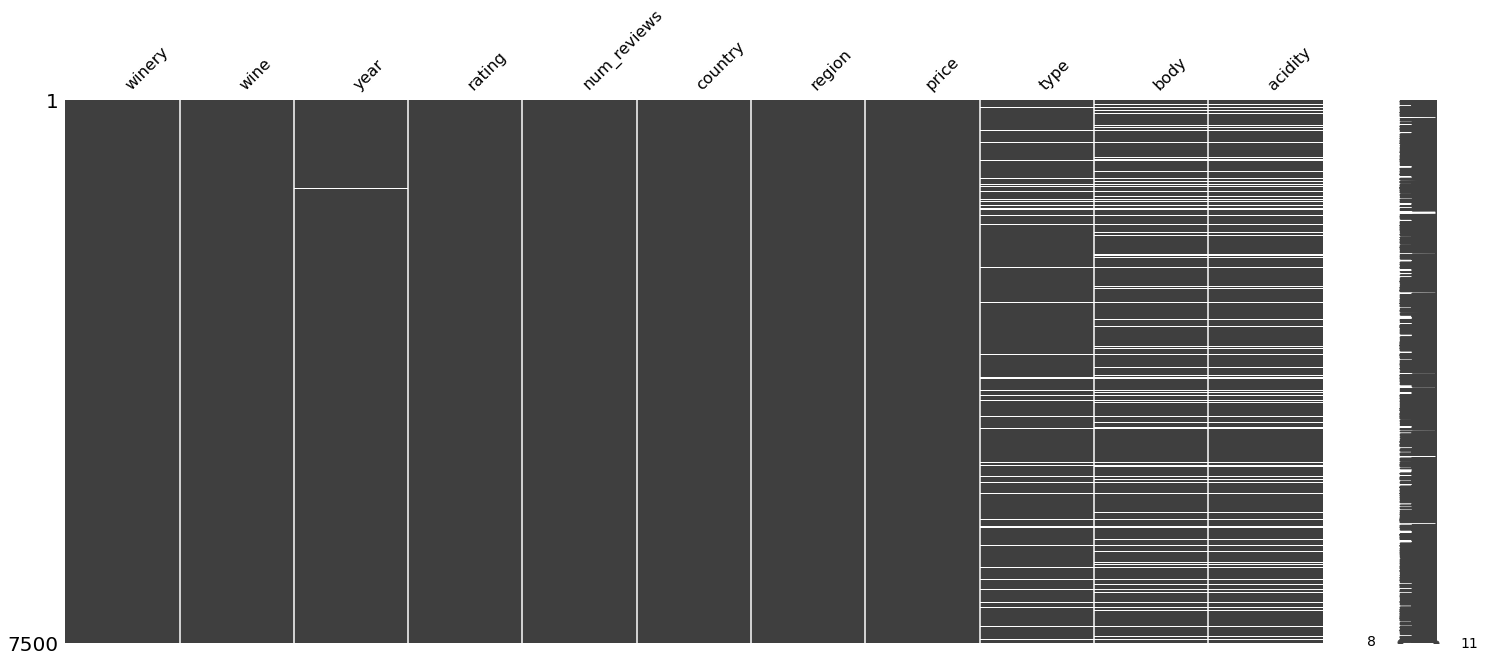

In [3]:
print(spanishWines.describe())
print('\n\n')
print(spanishWines.sample(5,random_state=7))
print('\n\n')
print(spanishWines.dtypes)
print('\n\n')
print('Missing data\n',spanishWines.isnull().sum(),'\n')
msno.matrix(spanishWines)

No outliers or otherwise unreasonable values appear in the descriptives. Note that year is missing, since it is assigned an object type, I will explore this issue below.

The target variable (i.e., price) is very skewed due to the inclusion of some quite expensive wines. To improve the perfomance of the model and the conformation of the data to the linear regression assumptions I decided to limit the data to wines with a price below or equal to 100€. Thus I limited the model to the prediction of mass consumption wines to the exclusion of more luxury ones (see below).

For the missing data analysis we see that ```year``` has only two rows with missing data but ```type```, ```body``` and ```acidity``` have a significant amount of missing data. Keeping in mind that the data were scraped and the distribition of the missing data on the graph above it is reasonable to conclude that missingness on the latter variables is due to some websites not including this kind of more secondary information. Note especially that many rows miss data on two or all three of the involved columns and that ```body``` and ```acidity``` have a higher number of missing data since these are even more specialized types of information than wine ```type```. Since removing data from whole websites may introduce bias in the model I finally imputed these data (see below). We should keep in mind though that the missingness may be related to the type of website/store (e.g., less specialized sites may be the ones not including the missing information) and since this is an unobserved variable some bias might still exist in the model even with imputation.

Moving on I removed the luxury wines.

In [4]:
spanishWines = spanishWines[spanishWines['price']<=100]
print(spanishWines.describe())

            rating   num_reviews        price         body      acidity
count  6962.000000   6962.000000  6962.000000  5807.000000  5807.000000
mean      4.233352    450.946280    34.622406     4.134321     2.954021
std       0.081411    689.523568    20.568057     0.577633     0.220670
min       4.200000     25.000000     4.990000     2.000000     1.000000
25%       4.200000    390.000000    18.900000     4.000000     3.000000
50%       4.200000    404.000000    28.300000     4.000000     3.000000
75%       4.200000    415.000000    48.960000     4.000000     3.000000
max       4.700000  32624.000000   100.000000     5.000000     3.000000


Note that after the removal of the expensive wines the majority of data still remain in the dataset.

For the next step I explored in greater detail the ```year``` variable.

In [5]:
pd.set_option("display.max_rows",1000)

print(spanishWines['year'].unique())
print('\n')
print(spanishWines['year'].value_counts())

['2020' '2012' '2017' '2016' '2019' '2011' '2018' '2004' '2015' '2014'
 'N.V.' '2005' '2006' '2001' '2013' '2010' '1994' '1999' '1995' '2021'
 '1996' '2008' '2002' '2000' '1985' nan '2009' '2007' '1970' '1998' '1964'
 '2003' '1986' '1987' '1978' '1988' '1990']


2011    1161
2016     859
2018     835
2015     830
2017     706
2012     504
2020     473
2014     342
2019     327
N.V.     275
2004     231
2005     179
2010      48
2013      46
2009      29
2006      20
2007      20
2008      19
2000       9
1994       6
2021       6
2001       5
2002       5
2003       4
1998       4
1995       3
1985       3
1999       3
1996       2
1970       1
1964       1
1986       1
1987       1
1978       1
1988       1
1990       1
Name: year, dtype: int64


We see that there is a category for non-vintage wines which is the reason for the assignment of the object type to the variable. Since all recent years are represented in the dataset I decided to keep the variable as is.

Note also that older years have a very low number of data included. Since I eventually used Lasso regression, any non-relevant categories were excluded automatically by the model.

Finally I removed the few missing data from the year variable.

In [6]:
spanishWines = spanishWines.dropna(subset='year')

I then procedeed to examine the rest of the categorical variables. We see that the variables look unproblematic with the excpetion of the country variable which has only one category and was consquently removed. The low counts of data for some categories were again taken care of by the penalty of the Lasso regression.

In [7]:
for name in ['winery','wine','country','region','type']:
    print('**',name,'**','\n',spanishWines[name].value_counts(),'\n')

** winery ** 
 Contino                                             455
La Rioja Alta                                       240
Sierra Cantabria                                    233
Artadi                                              231
Matarromera                                         230
Imperial                                            227
Losada                                              227
Sei Solo                                            225
Portal del Priorat                                  225
Vina Pedrosa                                        225
Ramon Bilbao                                        225
Matsu                                               224
La Vicalanda                                        223
Conreria d'Scala Dei                                223
Lustau                                              223
Campillo                                            223
Bodegas La Horra                                    223
Mar de Frades                    

Name: winery, dtype: int64 

** wine ** 
 Reserva                                                                   466
Gran Reserva                                                              451
Rioja Reserva                                                             238
El Viejo                                                                  224
Mirto                                                                     223
Corimbo I                                                                 223
Rioja Graciano                                                            223
Valdegines                                                                223
Altos de Losada                                                           222
Coleccion Privada                                                         222
Clos del Portal Somni                                                     222
Preludio                                                                  222
Gran Reserva Rioja    

In [8]:
spanishWines = spanishWines.drop('country',axis=1)

Next I proceded with the imputation of the missing data. For the ```type``` variable I simply imputed the generic categoty ```Red``` in the missing rows. After this step I also converted all the categorical variables in the dataset to One Hot encoded ones.

In [9]:
imputerForType = SimpleImputer(strategy='constant',fill_value='Red')
imputedType = imputerForType.fit_transform(spanishWines['type'].to_numpy().reshape(-1, 1))
spanishWines['type'] = imputedType
print(spanishWines['type'].sample(5),'\n')
print(spanishWines[['type']].isnull().sum(),'\n\n\n')

spanishWines = pd.get_dummies(spanishWines,drop_first=False)
print(spanishWines.sample(5))

3594               Rioja Red
3197    Ribera Del Duero Red
6885    Ribera Del Duero Red
4227                     Red
2604               Rioja Red
Name: type, dtype: object 

type    0
dtype: int64 



      rating  num_reviews  price  body  acidity  winery_A Coroa  winery_Aalto  \
5895     4.2          390  16.76   4.0      3.0               0             0   
3788     4.2          404  77.36   4.0      3.0               0             0   
702      4.4          798  59.90   4.0      3.0               0             0   
2463     4.2          404  77.36   4.0      3.0               0             0   
2660     4.2          410  22.99   4.0      3.0               0             0   

      winery_Abadal  winery_Abadia Retuerta  winery_Abel Mendoza Monge  ...  \
5895              0                       0                          0  ...   
3788              0                       0                          0  ...   
702               0                       0                          0  ... 

For the ```body``` and ```acidity``` variables I used multivariate imputation with the default Bayesian Ridge regression of the Scikit ```IterativeImputer``` for estimating the missing data.

In [10]:
imputerNumerical = IterativeImputer(skip_complete=True)
imputedDataMatrix = imputerNumerical.fit_transform(spanishWines.to_numpy())
spanishWines[spanishWines.columns] = imputedDataMatrix

print(spanishWines[['body','acidity']].isnull().sum(),'\n')
print(spanishWines[['body','acidity']].describe())

body       0
acidity    0
dtype: int64 

              body      acidity
count  6961.000000  6961.000000
mean      4.126213     2.957771
std       0.558360     0.208736
min       2.000000     1.000000
25%       4.000000     3.000000
50%       4.000000     3.000000
75%       4.015613     3.000000
max       5.015613     3.052829


We see in the output above that all the missing data were filled in and that the ranges of the variables (1-5 in both cases) were not violated.

With the missing values taken care of I examined more closely the distribution of the numerical variables. We see that ```price``` and ```body``` approximate normality while the rest of the variables are skewed. We also note that ```rating``` has a very limited range although this does not present problems in the training of a Lasso regression model.

Text(0.5, 1.0, 'Acidity')

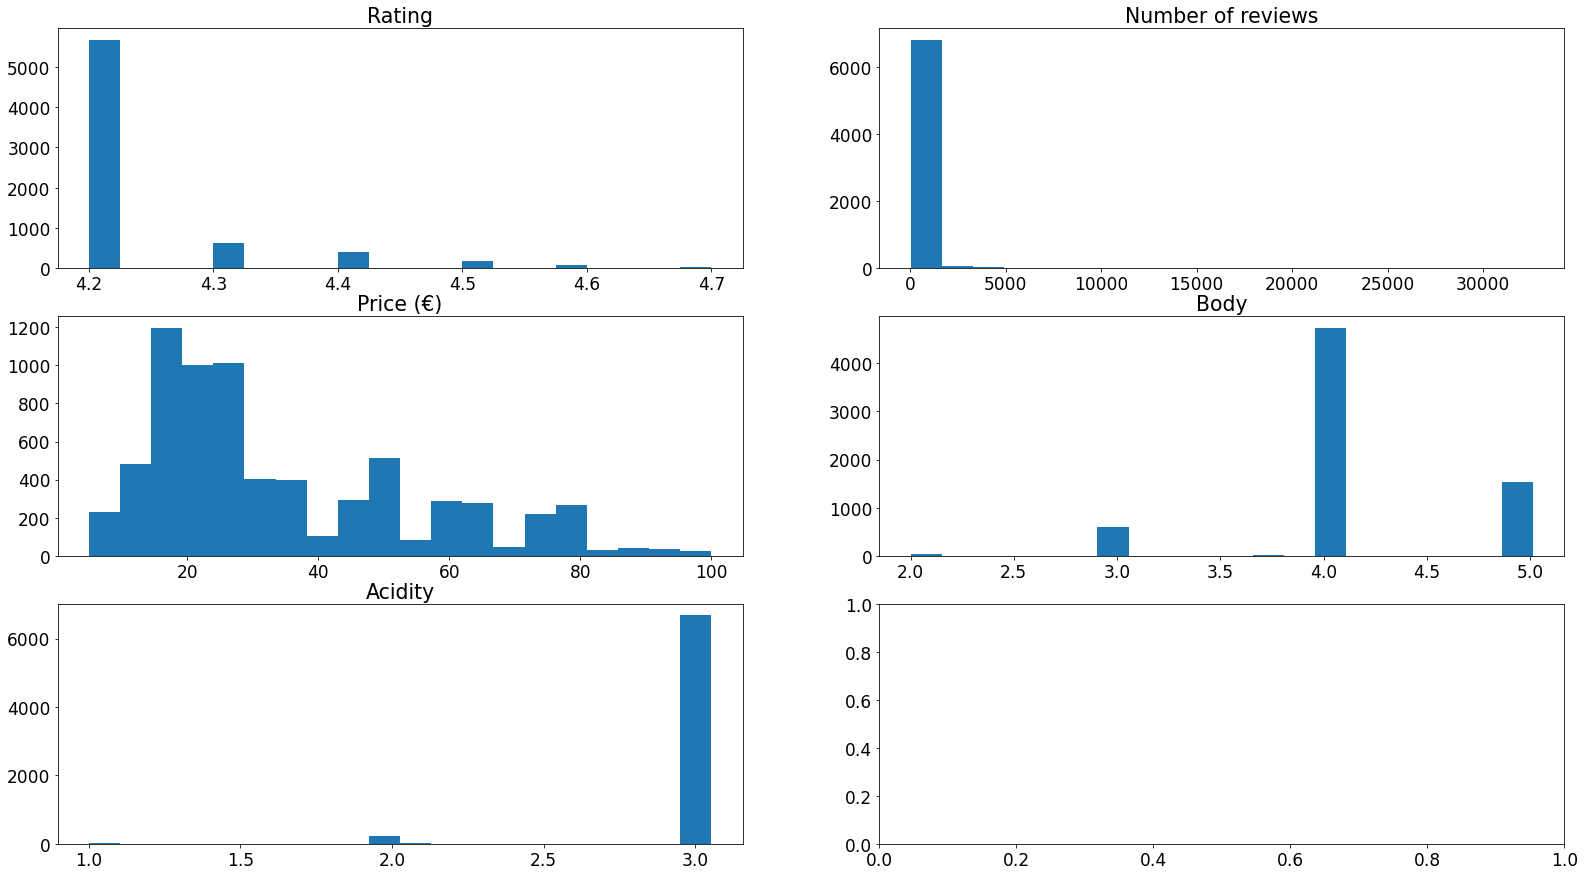

In [11]:
plt.rcParams.update({'font.size': 17})
fig, axs = plt.subplots(3,2,figsize=(27,15))
axs[0,0].hist(spanishWines['rating'],bins=20)
axs[0,0].set_title('Rating')
axs[0,1].hist(spanishWines['num_reviews'],bins=20)
axs[0,1].set_title('Number of reviews')
axs[1,0].hist(spanishWines['price'],bins=20)
axs[1,0].set_title('Price (€)')
axs[1,1].hist(spanishWines['body'],bins=20)
axs[1,1].set_title('Body')
axs[2,0].hist(spanishWines['acidity'],bins=20)
axs[2,0].set_title('Acidity')

To examine whether the data meet the assumptions of linear regression I ran an ordinary least squares regression and plotted the residuals against the model's predictions.

In [12]:
def residualsPlot(model,predictionSet,targetSet):
    fig = plt.figure()
    plt.rcParams.update({'font.size': 8})
    predictedValues = model.predict(predictionSet)
    plt.scatter(predictedValues,predictedValues-targetSet,label='Residual Plot') 
    plt.xlabel('Predicted Y')
    plt.ylabel('Residuals')

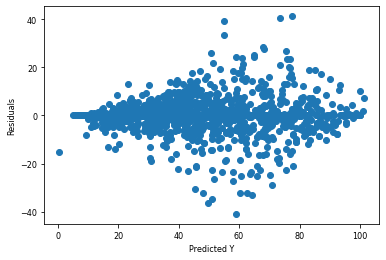

In [13]:
residualsModel = linear_model.LinearRegression(fit_intercept=True) 
residualsModel.fit(spanishWines.drop('price',axis=1),spanishWines['price'])

residualsPlot(residualsModel,spanishWines.drop('price',axis=1),spanishWines['price'])

We see that linearity and normality are satisfied. There is a small degree of heteroscedasticity but I judged this to be acceptable.

Next I standardized the feature variables and centered the target variable so as to render the data suitable for Lasso regression.

In [14]:
targetSet = spanishWines['price'].to_numpy()
featureSet = spanishWines.drop(['price'],axis=1)

featureSetStd = featureSet.copy()
featureScaler = StandardScaler(with_mean=True, with_std=True)
featureSetStd[['rating','num_reviews','body','acidity']] = featureScaler.fit_transform(featureSet[['rating','num_reviews','body','acidity']])
featureSetStd = featureSetStd.to_numpy()

targetSet2d = targetSet.reshape(-1, 1)
targetScaler = StandardScaler(with_mean=True,with_std=False)
targetSetCentered = targetScaler.fit_transform(targetSet2d)

print(featureSetStd.shape,featureSetStd.dtype)
print(targetSetCentered.shape,targetSetCentered.dtype)

(6961, 1338) float64
(6961, 1) float64


Finally I created a Lasso model with Scikit's ```LassoCV```. ```LassoCV``` performs by default a 5-fold cross-valdation across a range of possible Lasso hyperparameter values  (called ```alphas``` in this setting) and automatically picks the optimal hyperparameter. The range of ```alphas``` that I chose for this model was from 0.01 to 0.99 with a step of 0.01.

In [15]:
lassoModel = LassoCV(alphas=np.arange(0.01,1,0.01),fit_intercept=True)
lassoModel.fit(featureSetStd,np.ravel(targetSetCentered))

LassoCV(alphas=array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]))

In [16]:
print('Optimal alpha: ',lassoModel.alpha_)
print('Mean MSE: %.2f, S.D. MSE: (%.2f)'%(lassoModel.mse_path_[-1].mean(),lassoModel.mse_path_[-1].std()))
print('Root mean of MSE: %.2f'%(np.sqrt(lassoModel.mse_path_[-1].mean())))

Optimal alpha:  0.01
Mean MSE: 56.72, S.D. MSE: (3.90)
Root mean of MSE: 7.53


After the completion of the training and validation of the model we see that the optimal hyperparameter has a value of 0.01 with the root of the mean of the Mean Square Error across the five folds, at 7.53€. This latter value demonstrates that the model has a low-to-moderate error and therefore that it is useful for the prediction of unknown data.